### This is the notebook for analyzing LUAD data

In [82]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

import mygene
mg = mygene.MyGeneInfo()

cancer_type = "LUAD"
omic_type = "proteomics"

##### Step 1: organize the data into anndata object

In [ ]:

# Tumor file
sample_type = "Tumor"
file_tumor = f"../../MultiOmics_cancer_landscape_data/{cancer_type}/Data/{cancer_type}_{omic_type}_gene_abundance_log2_reference_intensity_normalized_{sample_type}.txt"

# Normal file
sample_type = "Normal"
file_normal = f"../../MultiOmics_cancer_landscape_data/{cancer_type}/Data/{cancer_type}_{omic_type}_gene_abundance_log2_reference_intensity_normalized_{sample_type}.txt"

# Read data
df_tumor = pd.read_csv(file_tumor, sep="\t")
df_normal = pd.read_csv(file_normal, sep="\t")

# Rename the sample names (orignal sample name are same in tumor and normal file, majority of normal samples are matched normal controls)
df_normal = df_normal.rename(columns={col: f"{col}_N" for col in df_normal.columns if col != "idx"})
df_tumor = df_tumor.rename(columns={col: f"{col}_T" for col in df_tumor.columns if col != "idx"})
df_merged = pd.merge(df_normal, df_tumor, on="idx", how="inner")

# The transposed_df is now in the correct format with samples as rows and genes as columns
df_merged.set_index(df_merged.columns[0], inplace=True)
df_transposed = df_merged.T

In [ ]:
df_transposed

idx,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000283632.3,ENSG00000284024.2,ENSG00000284194.3,ENSG00000284691.1,ENSG00000284753.2,ENSG00000284862.3,ENSG00000285025.1,ENSG00000285723.1,ENSG00000286053.1,ENSG00000286140.1
C3N-01799_N,23.367549,NaN,25.513388,23.616921,18.392785,23.508491,29.815637,24.546117,27.098827,21.540122,...,22.247932,NaN,23.525169,NaN,NaN,18.765936,21.938087,21.291301,NaN,24.219367
C3L-01890_N,23.187762,NaN,25.522596,23.764889,18.044385,23.800708,29.671583,25.206800,26.896717,21.522963,...,22.203130,NaN,23.643589,NaN,NaN,18.267258,21.846182,21.696401,NaN,24.177053
C3N-00572_N,23.471186,NaN,25.627892,23.568230,18.715531,23.404397,29.216400,24.845913,26.649770,21.817662,...,22.443879,NaN,23.231191,NaN,NaN,18.330053,21.992328,21.439679,NaN,24.293062
C3N-02423_N,23.577705,NaN,25.548251,23.800715,18.198743,23.418971,30.007452,25.134235,26.710234,21.492112,...,22.168474,NaN,23.448289,NaN,NaN,18.743009,21.822814,21.437328,NaN,24.373659
C3N-02729_N,23.285115,NaN,25.477157,23.629144,NaN,23.458396,29.841986,24.969321,26.906733,21.568706,...,22.486878,NaN,23.087765,NaN,NaN,17.735828,22.261919,21.767022,18.235270,24.258260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N-02003_T,24.367574,NaN,25.935052,23.333010,17.920082,23.523027,28.707149,25.392018,25.767390,20.113559,...,21.922762,NaN,23.718630,18.701100,NaN,NaN,22.370596,22.177774,NaN,24.074833
C3N-00175_T,24.012324,NaN,25.688440,24.005128,17.107236,23.358900,29.216462,25.877800,27.652654,20.170560,...,22.341231,13.718722,23.319345,18.729621,NaN,NaN,22.399997,21.500194,18.924742,24.343111
C3N-01823_T,23.426271,NaN,25.748153,23.537459,18.589590,23.627631,29.470174,24.586393,27.041797,22.148952,...,21.818248,14.267978,23.734106,18.332803,NaN,NaN,22.947758,22.485201,18.851061,24.376026
C3L-02549_T,24.236531,NaN,25.661462,24.188776,18.995931,23.292163,28.776425,25.187131,26.535060,21.187801,...,21.977006,13.861991,24.508084,19.838500,NaN,NaN,22.090255,21.775095,18.820080,24.344557


In [50]:
### Make the anndata object
obs=pd.DataFrame(
    index=df_transposed.index, 
    data={
        'SampleType': df_transposed.index.str[-1],  # Last character
        'Sample': df_transposed.index.str[:-2]      # All but last two characters
    }
)

var=pd.DataFrame(
    index=df_transposed.columns, 
    data={
        "ensembl_ids_clean" : [x.split(".")[0] for x in df_transposed.columns]
    }
)

adata = ad.AnnData(
    X=df_transposed,
    obs=obs,
    var=var
)

print(adata)

AnnData object with n_obs × n_vars = 211 × 12431
    obs: 'SampleType', 'Sample'
    var: 'ensembl_ids_clean'


In [ ]:
adata.var

In [52]:
### Get gene symbol for ensembl ids (cleaned)
gene_info = mg.querymany(adata.var['ensembl_ids_clean'], scopes="ensembl.gene", fields = "symbol", species="human")
gene_symbols = {item['query']: item.get('symbol', None) for item in gene_info}

# Create a DataFrame to map Ensembl IDs to Gene Symbols
gene_mapping = pd.DataFrame(list(gene_symbols.items()), columns=['ensembl_ids_clean', 'Gene'])

# Merge with adata.var to add Gene_Symbol
adata.var = adata.var.join(gene_mapping.set_index("ensembl_ids_clean"), on='ensembl_ids_clean', how='left')

assert (adata.var.index == df_transposed.columns).all()
assert (adata.obs.index == df_transposed.index).all()

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found dup hits:	[('ENSG00000175711', 2)]
7 input query terms found no hit:	['ENSG00000112096', 'ENSG00000130723', 'ENSG00000148362', 'ENSG00000168078', 'ENSG00000183791', 'ENS


In [60]:
assert (adata.var.index == df_transposed.columns).all()
assert (adata.obs.index == df_transposed.index).all()

In [ ]:
adata.var_names
adata.var
#adata.obs


In [54]:
object_file = f"../../MultiOmics_cancer_landscape_data/{cancer_type}/Object/{cancer_type}_{omic_type}.h5ad"

adata.write(object_file, compression="gzip")

##### Step 2: ML

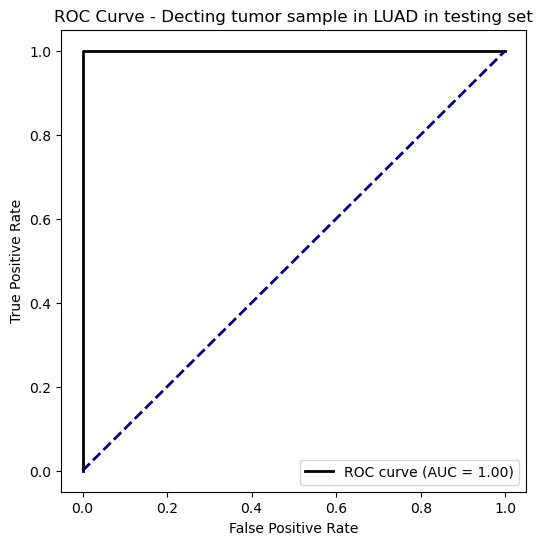

In [85]:
### Main performance 

# Load data
object_file = f"../../MultiOmics_cancer_landscape_data/{cancer_type}/Object/{cancer_type}_{omic_type}.h5ad"
adata = ad.read_h5ad(object_file)

X = adata.X
y_ori = adata.obs["SampleType"].values
#samples = adata.obs["Sample"].values  # sample names or IDs
samples_type = adata.obs["SampleType"].values
samples = adata.obs.index

# Encode labels
# LabelEncoder assigns integers alphabetically by default, so if your labels are "N" and "T" you’ll usually get "Normal" = 0, "Tumor" = 1
encoder = LabelEncoder()
y = encoder.fit_transform(y_ori)

# Ensure "Normal" = 0, "Tumor" = 1
if encoder.transform(["T"])[0] == 0:
    y = 1 - y  # flip labels

# Split train/test and also get the indices of the test set
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, range(len(y)), test_size=0.3, random_state=42, stratify=y, shuffle=True
)


# Train Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# Predict probabilities
y_proba = rf.predict_proba(X_test)[:, 1]  # Probability of class 1 (Tumor)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Compute AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color = "black", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color = "navy", lw=2, linestyle= "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - Decting tumor sample in {cancer_type} in testing set")
plt.legend(loc="lower right")

# Save to PDF
pdf_file = f"../results/figures/{cancer_type}_{omic_type}_ROC_in_testing_set.pdf"
plt.savefig(pdf_file, format="pdf", bbox_inches="tight")

plt.show()


    idx_test       Sample Sample_Type  y_test  y_pred
0         32  C3L-00095_N           N       0   0.054
1         51  C3L-01632_N           N       0   0.026
2          2  C3N-00572_N           N       0   0.006
3        103  C3N-00572_T           T       1   0.850
4         21  C3L-01682_N           N       0   0.002
5         92  C3L-02350_N           N       0   0.002
6         52  C3N-02155_N           N       0   0.024
7        123  C3L-01682_T           T       1   0.762
8         60  C3N-02158_N           N       0   0.006
9        162  C3N-02002_T           T       1   0.954
10        95  C3N-02003_N           N       0   0.038
11       147  C3N-00549_T           T       1   0.980
12       134  C3L-00279_T           T       1   0.980
13       133  C3N-02424_T           T       1   0.990
14       172  C3N-00294_T           T       1   0.994
15        41  C3N-00549_N           N       0   0.008
16       181  C3N-00293_T           T       1   0.866
17       208  C3N-01823_T   

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_52763/3831313494.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=performance, x="Sample_Type", y="y_pred", palette=custom_palette)


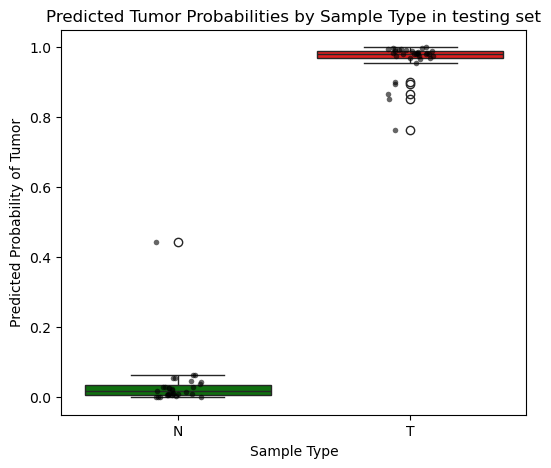

In [86]:

### Create performance DataFrame with Sample info and visualize the proba in testing set
performance = pd.DataFrame({
    "idx_test": idx_test,
    "Sample": samples[idx_test],   # sample names
    "Sample_Type": samples_type[idx_test],
    "y_test": y_test,
    "y_pred": y_proba
})

print(performance)

performance_sort = performance.sort_values("y_pred").reset_index(drop=True)

#pd.set_option("display.max_rows", None)
#print(performance_sort)

### Boxplot on the prediction score in testing set
custom_palette = {"N": "green", "T": "red"}

plt.figure(figsize=(6,5))
sns.boxplot(data=performance, x="Sample_Type", y="y_pred", palette=custom_palette)
sns.stripplot(data=performance, x="Sample_Type", y="y_pred", color="black", size=4, jitter=True, alpha=0.6)
plt.ylabel("Predicted Probability of Tumor")
plt.xlabel("Sample Type")
plt.title("Predicted Tumor Probabilities by Sample Type in testing set")

# Save to PDF
pdf_file = f"../results/figures/{cancer_type}_{omic_type}_Proba_in_testing_set.pdf"
plt.savefig(pdf_file, format="pdf", bbox_inches="tight")

plt.show()

In [87]:
### Explor the contributing features

# Get feature importance from trained RF
importances = rf.feature_importances_

# Create a DataFrame linking features to importance
feature_importance = pd.DataFrame({
    "Gene": adata.var['Gene'],  # feature names from adata.var
    "Ensembl": adata.var['ensembl_ids_clean'],
    "Importance": importances
})
feature_importance.index = adata.var.index

feature_importance_sort = feature_importance.sort_values(by="Importance", ascending=False)

# Show top 20 most important features
print(feature_importance_sort.head(100))



                          Gene          Ensembl  Importance
idx                                                        
ENSG00000117114.20      ADGRL2  ENSG00000117114    0.015945
ENSG00000196616.14       ADH1B  ENSG00000196616    0.013945
ENSG00000173210.19      ABLIM3  ENSG00000173210    0.013888
ENSG00000173473.11     SMARCC1  ENSG00000173473    0.012000
ENSG00000182010.11       RTKN2  ENSG00000182010    0.012000
ENSG00000112782.19       CLIC5  ENSG00000112782    0.012000
ENSG00000167110.18      GOLGA2  ENSG00000167110    0.011892
ENSG00000110047.18        EHD1  ENSG00000110047    0.011726
ENSG00000177469.13      CAVIN1  ENSG00000177469    0.010256
ENSG00000024422.12        EHD2  ENSG00000024422    0.010000
ENSG00000251322.9       SHANK3  ENSG00000251322    0.010000
ENSG00000135387.21     CAPRIN1  ENSG00000135387    0.010000
ENSG00000134333.14        LDHA  ENSG00000134333    0.009946
ENSG00000119865.9       CNRIP1  ENSG00000119865    0.009891
ENSG00000174175.17        SELP  ENSG0000

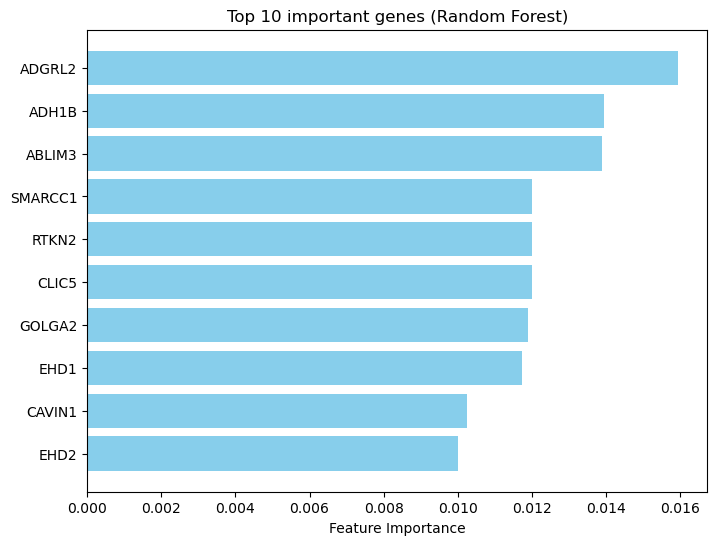

In [98]:
top_n = 10
plt.figure(figsize=(8,6))
plt.barh(
    feature_importance_sort['Gene'][:top_n][::-1],
    feature_importance_sort['Importance'][:top_n][::-1],
    color='skyblue'
)
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} important genes (Random Forest)")
plt.show()


/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_52763/3961997358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


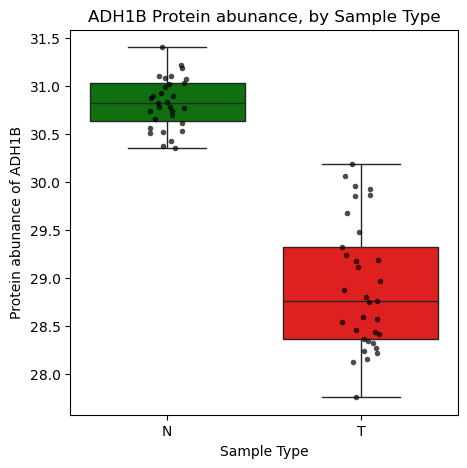

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_52763/3961997358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


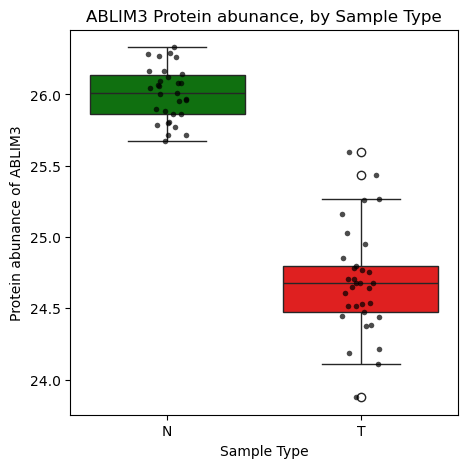

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_52763/3961997358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


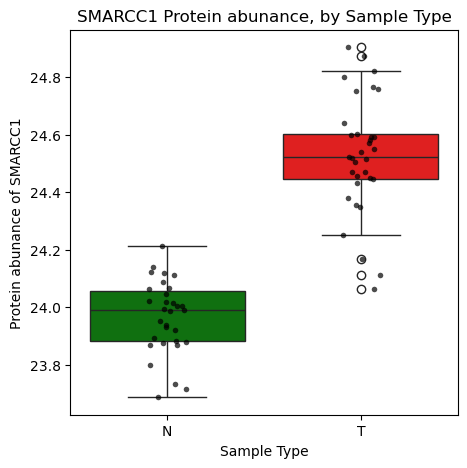

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_52763/3961997358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


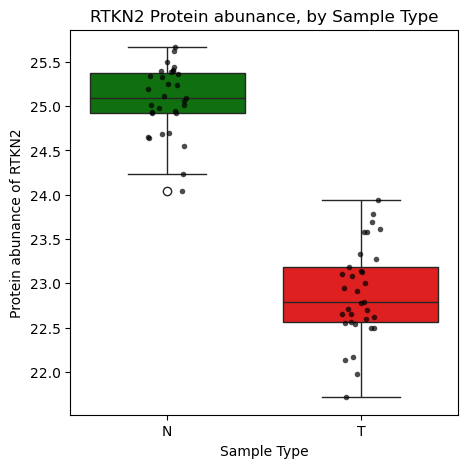

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_52763/3961997358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


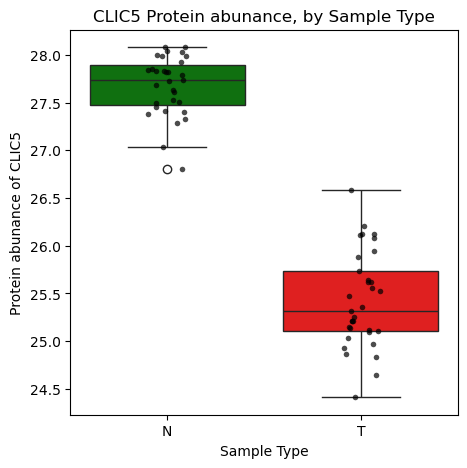

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_52763/3961997358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


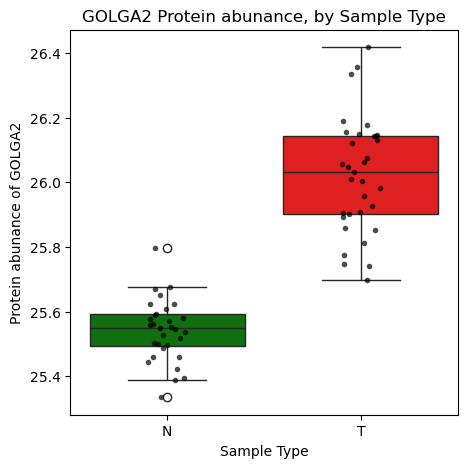

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_52763/3961997358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


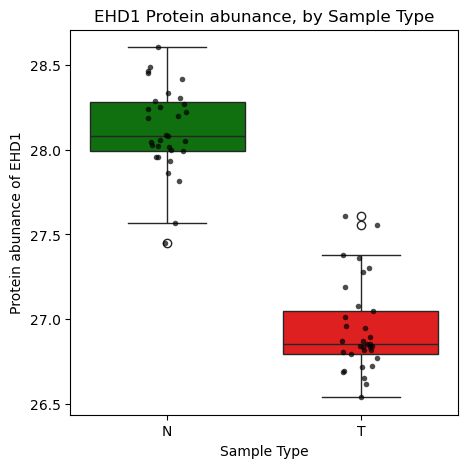

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_52763/3961997358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


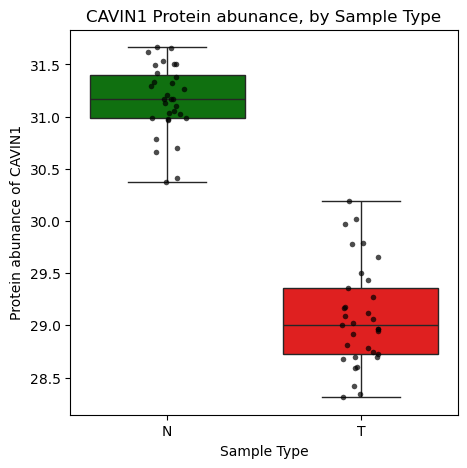

/var/folders/bs/xtz8xkb56vl8bb082l_qg1p00000gq/T/ipykernel_52763/3961997358.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


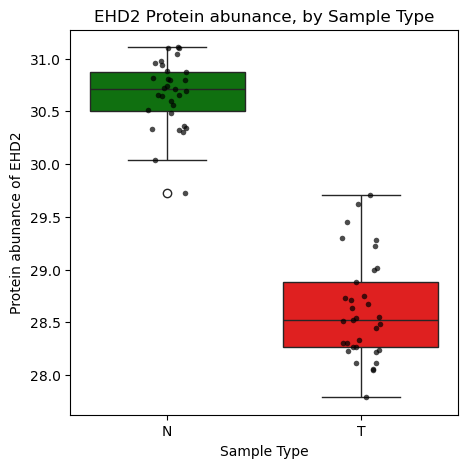

In [ ]:

### Boxplot Select the feature(s) you want to visualize
#selected_genes = ["ENSG00000117114.20", "ENSG00000196616.14", "ENSG00000110047.18", "ENSG00000177469.13"]  # replace with your gene IDs or names
selected_genes = feature_importance_sort.iloc[1:10, ].index.to_list()

df = pd.DataFrame(
    adata[idx_test].X, 
    index=adata[idx_test].obs.index,
    columns=adata.var.index  # or adata.var['Gene'] if you prefer gene symbols
).join(adata[idx_test].obs)


for gene in selected_genes:
    
    plt.figure(figsize=(5,5))
    
    sns.boxplot(
        data=df, 
        x="SampleType", 
        y=gene, 
        palette={"N": "green", "T": "red"}
    )
    
    sns.stripplot(
        data=df, 
        x="SampleType", 
        y=gene, 
        color="black", 
        size=4, 
        jitter=True, 
        alpha=0.7
    )
    
    plt.ylabel(f"Protein abunance of {adata.var.loc[gene, 'Gene']}")
    plt.xlabel("Sample Type")
    plt.title(f"{adata.var.loc[gene, 'Gene']} Protein abunance, by Sample Type")
    
    plt.show()

